# Few-Shot Learning

<!-- **Challenge:** [Omniglot](https://github.com/brendenlake/omniglot), the "transpose" of MNIST, with 1,623 character classes, each with 20 examples. Is it possible to build a few-shot classifier with a target of <35% error rate? -->

Humans exhibit a strong ability to acquire and recognize new patterns. In particular, we observe that when presented with stimuli, people seem to be able to understand new concepts quickly and then recognize variations on these concepts in future percepts. [Machine learning](https://wikipedia.com/wiki/Machine_learning) has been successfully used to achieve *state-of- the-art* performance in a variety of applications such as web search, spam detection, caption generation, and speech and image recognition. However, these algorithms often break down when forced to make predictions about data for which little supervised information is available. We desire to generalize to these unfamiliar categories without necessitating extensive retraining which may be either expensive or impossible due to limited data or in an online prediction setting, such as web retrieval.

One particularly interesting task is classification under the restriction that we may only observe a single example of each possible class before making a prediction about a test instance. This is called [One-Shot Learning Problem](https://wikipedia.org/wiki/One-shot_learning). This should be distinguished from [Zero-shot Learning](https://analyticsindiamag.com/what-is-zero-shot-learning/), in which the model cannot look at any examples from the target classes.

[Few-Shot Learning](https://codeburst.io/understanding-few-shot-intelligence-as-a-meta-learning-problem-7823a4cd4a0c) on the other hand *(which is the primary focus of this notebook)*; is a special case of one-shot learning that tries to learn from *a very small set of training examples* rather than one –as in the one-shot learning case.


## Exploring the Dataset

**[Omniglot](https://github.com/brendenlake/omniglot)** is a collection of **1,623** hand drawn characters from **50 alphabets**. Each of the 1,623 characters is drawn online via *Amazon's Mechanical Turk* by 20 different people at resolution of `105x105`. It is sometimes reffered to as the ["Trasnpose of MNIST"](), since it has 1,623 types of character with only 20 examples each *(perfect for few-shot learning)*, in contrast to [MNIST](https://yann.lecun.com/exdb/mnist/) having thousands of examples for only 10 digits *(not easy to come-by for real-word use case)*.

![Omniglot Dataset](images/omniglot.png)


### Structure of Omiglot Datasets

```sh
~ tree datasets/extracted -L 1
datasets/extracted
├── all_runs
├── images_background
└── images_evaluation

3 directories, 0 files
```

Omniglot has 3 different dataset serving different purposes.

- **`all_runs`**          - One-shot task.
- **`images_background`** - Training set.
- **`images_evaluation`** - Validation/ evaluation set.

> **Usage:** The **`images_background`** will be used for training *a Model* for *Few-shot Learning* and then validated on **`images_evaluation`**. While the **`all_runs`** will be used for *One-shot task*.

#### Training/Validation Dataset Structure

The training data contains 30 different *Alphabets* and the validation data contains 20 different alphabets *(that aren't in the training set)*, each containing *Characters* written differently.

```sh
$datasets/extracted$ ~ tree images_background -L 2
images_background
├── Alphabet_of_the_Magi
├── Anglo-Saxon_Futhorc
├── Arcadian
...
├── Sanskrit
├── Syriac_(Estrangelo)
├── Tagalog
└── Tifinagh

30 directories, 0 files
```

#### Alphabet Structure

A single *Alphabet* contains different *Characters*, each with 20 different *handwriting style*.

```sh
$datasets/extracted$ ~ tree images_background/Alphabet_of_the_Magi -L 2
images_background/Alphabet_of_the_Magi
├── character01
│   ├── 0709_01.png
│   ├── 0709_02.png
│   ├── 0709_03.png
│   ...
│   ├── 0709_18.png
│   ├── 0709_19.png
│   └── 0709_20.png
├── character02
│   ├── 0710_01.png
│   ├── 0710_02.png
│   ├── 0710_03.png
│   ...
│   ├── 0710_18.png
│   ├── 0710_19.png
│   └── 0710_20.png
...
├── character19
│   ├── 0727_01.png
│   ├── 0727_02.png
│   ├── 0727_03.png
│   ...
│   ├── 0727_18.png
│   ├── 0727_19.png
│   └── 0727_20.png
└── character20
    ├── 0728_01.png
    ├── 0728_02.png
    ├── 0728_03.png
    ...
    ├── 0728_18.png
    ├── 0728_19.png
    └── 0728_20.png

20 directories, 400 files
```

#### One-shot Task Structure

The **`all_runs`** folder consist of 20 runs each with a **training** and **test** folder.

```sh
$datasets/extracted$ ~ tree all_runs -L 2
├── run01
│   ├── class_labels.txt
│   ├── test
│   └── training
├── run02
│   ├── class_labels.txt
│   ├── test
│   └── training
...
├── run19
│   ├── class_labels.txt
│   ├── test
│   └── training
└── run20
    ├── class_labels.txt
    ├── test
    └── training
```

`class_labels.txt` consist of pairs of matching images in the `test` and `training` directories. The `test` and `training` directories contain 20 unique images each, where a single image in `test` matches another image in `training`.

The **One-shot** task is all about learning how to tell two images apart, i.e. Predict if two given images are of different or similar classes.

![One-shot Task](images/one-shot-task.png)


### Visualizing Dataset

Haven explored the data and looked into the file structures and what they mean, it's time to start looking at the actual images to see for ourselves what we're trying to do.

#### Training/Validation Dataset Visualization.

Since the training and validation dataset have similar file structure, it's safe to say it can be visulaized in a similar way. The file structures represent various *Alphabets* and side each Alphabet are different characters written differently.

> Visualization class has been nicely abstracted in the **`omniglot.Visualize`** class.

To use the `omniglot.Visualize` class, we need to make a few imports.

In [1]:
%matplotlib inline

# For OS operations.
import os

# For plotting model from SVG bytes string.
from IPython.display import SVG

# For Mathematical operations.
import numpy as np

# # For High-level ML operations.
# import keras
# import tensorflow as tf

# Helper package for omniglot's dataset & model.
import omniglot

Using TensorFlow backend.


The `omniglot.Visualize` has a relatively simple API. We provide the path to an Alphabet and then it plots a single letter (randommly) from 20 different characters of the Alphabet.

Firstly, extract the dataset if it isn't already extracted. This can be achieved by calling `omniglot.Dataset.extract(...)` method –which takes in a single required argument: `path` to a compressed file. It will be extracted to a default directory, but you can also provide `extract_dir`.

Already extracted to datasets/extracted/all_runs
Already extracted to datasets/extracted/images_background
Already extracted to datasets/extracted/images_evaluation


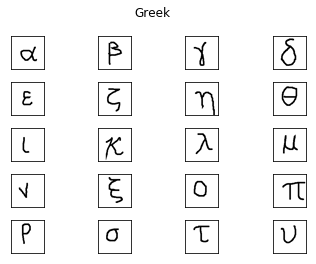

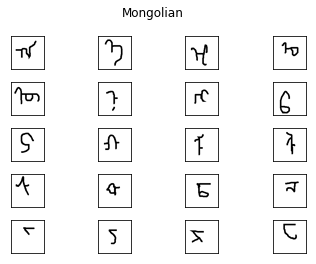

In [2]:
# Directory containing compressed files.
comp_dir = omniglot.compressed_dir

# Extract compressed dataset: `all_runs`, `images_background` & `images_evaluation`.
all_runs_dir = omniglot.Dataset.extract(os.path.join(comp_dir, 'all_runs.tar.gz'))
image_bg_dir = omniglot.Dataset.extract(os.path.join(comp_dir, 'images_background.tar.gz'))
image_ev_dir = omniglot.Dataset.extract(os.path.join(comp_dir, 'images_evaluation.tar.gz'))

# Visualize one random character from Greek alphabet of training set.
omniglot.Visualize.symbols(directory=os.path.join(image_bg_dir, 'Greek'))

# Visualize one random character from Mongolian alphabet of validation set.
omniglot.Visualize.symbols(directory=os.path.join(image_ev_dir, 'Mongolian'))

#### One-shot Task Visualization

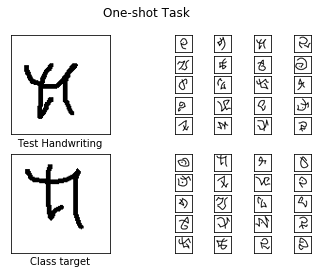

In [3]:
# Visualize the first run & select the 3rd image in the test directory
# and matching label in the train directory.
# (Simply put; emphaize the 3rd matching digits in "class_labels.txt").
omniglot.Visualize.runs(directory=os.path.join(all_runs_dir, 'run01'),
                        index=2, title='One-shot Task')

### Data Pre-processing

The `omniglot.Dataset` is made up of user friendly high level APIs to load, save, process, manage, format and manipulate dataset. Given the path to `image_background` or `image_evaluation` dataset, the `omniglot.Dataset` parses the path and creates image pairs and corresponding lables. It can also be run in training, testing or validation mode with the `mode` keyword argument which defaults to `Dataset.Mode.TRAIN`.

In [4]:
# To avoid writing `omniglot.Dataset`...
Dataset = omniglot.Dataset

# Create training data instance.
train_data = Dataset(path=image_bg_dir, mode=Dataset.Mode.TRAIN)
print(f'\nTraining data: {train_data.shape}')
print(f'train_data = {train_data}')

# Create validation data instance.
valid_data = Dataset(path=image_ev_dir, mode=Dataset.Mode.VALIDATE)
print(f'\nValidation data: {valid_data.shape}')
print(f'valid_data = {valid_data}')

Loading cached images & corresponding targets.

Training data: (20, 105, 105, 1)
train_data = Dataset(mode='TRAIN', cache=True, cache_dir='saved/images_background')
Loading cached images & corresponding targets.

Validation data: (20, 105, 105, 1)
valid_data = Dataset(mode='VALIDATE', cache=True, cache_dir='saved/images_evaluation')


## Exploring Models

### $N$-way One-shot learning

While One-shot learning requires a single training example, few-shot learning needs a very few subset of examples each from each classes. The number of training examples required for few-shot learning will be represented by $N$.

Therefore, given a tiny labelled training set $S$, which has $N$ examples, each vectors of the same dimension with a distinct label $y$.

$$ S = \{(x_i, y_i), ..., (x_N, y_N)\} $$

We're also given $\hat{x}$, the test example it has to classify. Since exactly one example in the training set has the right class, the aim is to correctly predict which $y \in S$ is the same as $\hat{x}$'s label, $\hat{y}$.

- Real world problems might not always have the constraint that exactly one image has the correct class.

- It's easy to generalize to k-shot learning by having there be $k$ examples for each $y_i$ rather than just one.

- When $N$ is higher, there are more possible classes that $\hat{x}$ can belong to, so it's harder to predict the correct one.

- Randomly guessing will average ${100 \over n}\%$ accuracy.

### The One-shot learning problem

To solve the One-shot learning problem, we're going to need a model that learns to tell images part rather than classify images using the normal [cross entropy loss function](https://rdipietro.github.io/friendly-intro-to-cross-entropy-loss/). Why classification won't work in this case is because there are very few images to learn from, therefore training a deep model on these few dataset is going to cause the model to [Overfit](https://en.wikipedia.org/wiki/Overfitting) to the few examples in the dataset.

However, what we need is a model that learns to tell image pairs apart. That is, given two images from the same class: the model outputs a distance $d$ which represent the how far these imgae pairs are in the feature space. A small value of $d$ means the images are the same, while a large value of $d$ means the images are different. This raises the question: *How small should "small" be and how large should "large" be?* Well, this is up to be learnt by the model. Let's call the threshold $\tau$ –Yes, yet another hyperparameter to worry about.

A popular model that does this is called the [Siamese Network](https://wikipedia.com/wiki/Siamese_network). The Siamese network architecture consist of a "twin neural net", hence the name. Both networks are [Convolutional Neural Network](http://cs231n.github.io/convolutional-networks/) with shared parameters.

![A simple 2 hidden layer siamese network for binary classification with logistic prediction p. The structure of the network is replicated across the top and bottom sections to form twin networks, with shared weight matrices at each layer.](images/weight-sharing.png)

> *A simple 2 hidden layer siamese network for binary classification with logistic prediction, $p$. The structure of the network is replicated across the top and bottom sections to form twin networks, with shared weight matrices at each layer.*

<!-- TODO: Finish up docs. -->

<!--
### One-Shot Learning Baseline over Nearest Neighbor

The simplest way to perform classification is with [K-Nearest Neighbors](https://www.analyticsvidhya.com/blog/2018/03/introduction-k-neighbours-algorithm-clustering/), but since there are only one example per class, we're only allowed 1 nearest neighbor lookup –which is really bad! K-Nearest Neigbors usually performs well with 5 neighbors or more *(but this also depends on dataset & it's sparsity)*.

Nearest Neighbor: This is just a way of measuring distance in a higher dimensional plane using distance metrics such as [Euclidean Distance](https://en.wikipedia.org/wiki/Euclidean_distance).

$$ \textrm{Euclidean Distance} = \sqrt{\sum_i^n{(q_i - p_i)^2}}$$

After calculating the Euclidean disance over `k` nearest neighbors. We then take the closest one:

$$ C(\hat{x}) = \underset{c \in S}{\operatorname{argmax}} \big\|\hat{x} - x_c\big\| $$

After calculating the Euclidean disance over `k` nearest neighbors. We then take the closest one:
-->

In [5]:
# Demo of Nearest neighbor lookup.

# Hyper-parameters.
epochs, batch_size = 3, 32
train_size, valid_size = len(train_data), len(valid_data)

### Model (Siamese Convolutional Neural Network)

A standard [Siamese Convolutional Neural Network](https://hackernoon.com/one-shot-learning-with-siamese-networks-in-pytorch-8ddaab10340e) with $L$ layers each with $N_l$ units is used, where $h_{1, l}$ represents the hidden vector in layer $l$ for the first twin, and $h_{2,l}$ denotes the same for the second twin. **Rectified Linear (ReLU) Units** is exclusively used in the first $L-2$ layers and sigmoidal units in the remaining layers.

The model consists of a sequence of convolutional layers, each of which uses a single channel with filters of varying size and a fixed stride of 1. The number of convolutional filters is specified as a multiple of 16 to optimize performance. The network applies a ReLU activation function to the output feature maps, optionally followed by max-pooling with a filter size and stride of 2. Thus the $k^{th}$ filter map in each layer takes the following form:

$$ a^{(k)}_{1, m} = \textrm{max-pool}(max(0, W^{(k)}_{l-1} \star h_{1, (l-1)} + b_l), 2) $$

$$ a^{(k)}_{2, m} = \textrm{max-pool}(max(0, W^{(k)}_{l-1} \star h_{2, (l-1)} + b_l), 2) $$

where $W^{l-1, l}$ is the 3-dimensional tensor representing the feature maps for layer $l$ and $\star$ is the valid convolutional operation corresponding to returning only those output units which were the result of complete overlap between each convolutional filter and the input feature maps.

In a more simple terms: The model consist a **Twin Neural Network Architecture***, where each network is a **Convolutional Neural Network (CNN)**. Each network is fed an image pair & the model learns to predict how far apart or close together these image pairs are in the feature space. More visually, the Twin Neural Net looks like this:

![Twin Network Architecture](images/Twin Network.png)

Where each network is made up of a CNN with the following configurations:

![Best convolutional architecture selected for verification task. Siamese twin is not depicted, but joins immediately after the 4096 unit fully-connected layer where the L1 component-wise distance between vectors is computed.](images/Siamese Network.png)

> Best convolutional architecture selected for verification task. Siamese twin is not depicted, but joins immediately after the 4096 unit fully-connected layer where the $L_1$ component-wise distance between vectors is computed.

### Learning

**Loss function.** Let $M$ represent the mini-batch size, where $i$ indexes the $i^{th}$ mini-batch. Now let $y(x^{(i)}_1, x^{(i)}_2)$ be a length-$M$ vector which contains the labels for the mini-batch, where $y(x^{(i)}_1, x^{(i)}_2) = 1$ whenever $x_1$ and $x_2$ are from the same character class and $y(x^{(i)}_1, x^{(i)}_2) = 0$ otherwise. A regularized cross-entropy objective is imposed on a binary classifier of the following form:

$$ \ell(x^{(i)}_1, x^{(i)}_2) = y(x^{(i)}_1, x^{(i)}_2)\log{p(x^{(i)}_1, x^{(i)}_2)} + (1 - y(x^{(i)}_1, x^{(i)}_2)) \log{(1 - p(x^{(i)}_1, x^{(i)}_2))} + \lambda^T\big|w\big|^2 $$

In [6]:
# # Define the Siamese Network Model with Triplet loss function.
# siamese_net = omniglot.SiameseNetwork(loss=omniglot.Loss.triplet_loss)

# # Train the Siamese network.
# siamese_net.train(train_data=train_data,
#                   valid_data=valid_data,
#                   epochs=epochs)

#### Using a custom EncoderNetwork architecture

Results from the Siamese Network is not too great, although better than a Nearest Neighbor lookup. This begs the question: *How do we optimize this network for more accurate predictions?* The answer comes in form of using a slightly similar but new architecture which ensures both image pairs shares the same weights and encodes separate feature mapping for each image pair. **`omniglot.EncoderNetwork`** contains the implementation of this network architecture.

![Twin Network Architecture](images/Twin Network.png)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 4096)         10636096    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 4096)         0           sequential_1[1][0]               
          

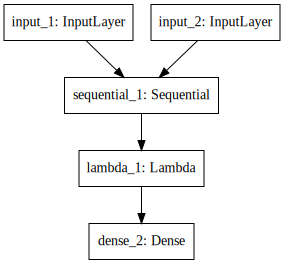

In [7]:
# Create a network instance to train dataset.
encoder_net = omniglot.EncoderNetwork()

# Visualize model architecture.
SVG(encoder_net.plot_model(show_layer_names=True, show_shapes=False))

In [8]:
# Train the network.
encoder_net.train(train_data=train_data,
                  valid_data=valid_data,
                  epochs=epochs)

Loading model from saved/models/network.h5
Epoch 1/3
128/128 [==============================] - 1820s 14s/step - loss: 0.4632 - acc: 0.7894 - val_loss: 0.4957 - val_acc: 0.7651
Epoch 2/3
  8/128 [>.............................] - ETA: 23:44 - loss: 0.4271 - acc: 0.7871
Training interrupted by user!

-----------------------------------------------------------------
Saving model...
Saved model weights to "saved/models/network.h5"!
-----------------------------------------------------------------



### Dataset & Model (Interesting Fact)

One cool thing I noticed about training on pairs is that there are quadratically many possible pairs of images to train the model on, making it hard to overfit. Say we have $C$ examples each of $E$ classes. Since there are $C \cdot E$ images total, the total number of possible pairs is given by:

$$\binom{C \cdot E}{2} = \frac{(C \cdot E)!}{2!(C \cdot E - 2)!}$$

For omniglot with its 20 examples of 964 training classes, this leads to $185,849,560$ possible pairs, which is huge! However, the siamese network needs examples of both same and different class pairs. There are $E$ examples per class, so there will be $\binom{E}{2}$ pairs for every class, which means there are $N_{same} = \binom{E}{2} \cdot C$ possible pairs with the same class - $183,160$ pairs for omniglot. Even though $183,160$ example pairs is plenty, it’s only a thousandth of the possible pairs, and the number of same-class pairs increases quadratically with $E$ but only linearly with $C$. This is important because the siamese network should be given a $1:1$ ratio of same-class and different-class pairs to train on - perhaps it implies that pairwise training is easier on datasets with lots of examples per class.

In [8]:
encoder_net.load_model()

Loading model from saved/models/network.h5


In [9]:
# Nearest Neighbor lookup benchmark.
nearest_neighbor = omniglot.Benchmark(data=valid_data)
nn_accuracy = nearest_neighbor.score(n=10)

print('Nearest Accuracy: {:.2%}'.format(nn_accuracy))

10-way few-shot task w/ 329 trials = 10.03%
Nearest Accuracy: 10.03%


In [ ]:
trials, resume, ways = 10, False, np.arange(0, 50, 10)

# Store list of accuracies for `n` ways.
val_acc, train_acc, nn_acc = [], [], []

for n in ways:
    # There's no 0-way few-shot learning (or Zero-shot learning).
    if n == 0:
        n += 1

    # Log progress.
    print(f'\rEvaluating {n:,} of {ways[-1]}-way few-shot tasks...', end='')

    # Validation accuracies on one-shot task.
    val_acc.append(valid_data.test_one_shot_task(encoder_net, n,
                                                 trials, verbose=0))

    # Train accuracies on one-shot task.
    train_acc.append(train_data.test_one_shot_task(encoder_net, n,
                                                   trials, verbose=0))

    # Nearest neighbor lookup on one-shot task.
    nn_acc.append(nearest_neighbor.score(n=10, trials=trials,
                                         verbose=0))

Evaluating 1 of 40-way few-shot tasks...

In [ ]:
p, t = valid_data.one_shot_task(3)
p.shape, t.shape

pred = encoder_net(p)

print(f'Predicted: {np.ravel(pred)}')
print(f'Target la: {t}')

In [ ]:
# Visualize Performance metrics for Few-shot learning.
omniglot.Visualize.accuracies(ways=ways, train=train_acc,
                              valid=val_acc, benchmark=nn_acc)

### Roadmap


#### Optimization & Data Augmentation

This model was pretty good at differentiating pairs of images, however, there are a few concepts that wasn't implemented here mainly because of computational resources like layerwise learning rates/momentum, data augmentation with distortions, bayesian hyperparemeter optimization and also more training epochs.

#### Using Deep Reinforcement Learning

A new way to approach this problem, rather than using Supervised learning, [Reinforcement Learning]() can also be leveraged to learn how to distinguish image pairs.

**Setup for Deep Reinforcement learning:** A policy network *(which architecture may be similar to that of a Simamese Network or something completely different)* is trained. The model learns a policy $\pi$ that maps image pairs to correct predictions –similar or dissimilar. In Reinfocement learning vocabulary, the image pairs can be thought of as *states* $S$ while predictions are *actions* $a$, on successful prediction the agent recieves a *reward* (+1) $R(s, a)$ otherwise it recieves a *punishment* (-1). The agent spits out a policy $\pi$ which maps state to action, $\pi(s) \to a$. The network is trained using a vanilla [Policy Gradients]() *(or any other RL training techniques like Actor-critic, Deep-Q, Contextual bandit, etc)*, with the sole purpose of maximizing rewards *(i.e. correctly classifying images as either similar or dissimilar)*.

#### Using Evolutionary Algorithms

Through the process of trial and error through many generations, the model learns how to best classify images as either *similar or dis-similar*. Evolutionary algorithm's fitness function should encode how well a model is able to generalize to new unseen image pairs or